In [ ]:
!pip install ta

In [73]:
!pip install tensorflow

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
import seaborn as sns
import matplotlib.pyplot as plt






In [52]:
# import GME data
df = yf.Ticker("GME")
df = GME.history(period="10y")
df.reset_index(inplace=True)
df.drop(['Dividends', 'Stock Splits', 'Date'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,8.064222,8.186436,7.959194,8.169250,6061600
1,8.180709,8.249455,8.069953,8.243726,5638800
2,8.260912,8.272370,8.165432,8.211263,4498400
3,8.201713,8.430865,8.192165,8.398401,6159200
4,8.400312,8.484334,8.186437,8.327747,6796400


In [53]:
# calculate the technical indicators
df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
df['SMA20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
df['MACD'] = MACD(df['Close']).macd()
df['BB_high'] = BollingerBands(df['Close']).bollinger_hband()
df['BB_low'] = BollingerBands(df['Close']).bollinger_lband()
df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,RSI,SMA20,MACD,BB_high,BB_low,OBV
25,8.455691,8.495793,8.323929,8.490064,3594000,63.104189,8.085802,0.088081,8.624800,7.546803,16230400
26,8.490062,8.581723,8.404130,8.539712,3046400,64.607510,8.114445,0.102711,8.685071,7.543819,19276800
27,8.551170,8.711576,8.541622,8.612277,6144800,66.740545,8.150250,0.118792,8.750688,7.549813,25421600
28,8.646649,8.824241,8.618005,8.791779,4631600,71.341660,8.197608,0.144356,8.841956,7.553260,30053200
29,8.818514,9.026660,8.705847,8.971281,6262000,75.057633,8.252796,0.177059,8.960557,7.545034,36315200


In [54]:
#create target column
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

,Open,High,Low,Close,Volume,RSI,SMA20,MACD,BB_high,BB_low,OBV,Target
25,8.455691,8.495793,8.323929,8.490064,3594000,63.104189,8.085802,0.088081,8.624800,7.546803,16230400,1
26,8.490062,8.581723,8.404130,8.539712,3046400,64.607510,8.114445,0.102711,8.685071,7.543819,19276800,1
27,8.551170,8.711576,8.541622,8.612277,6144800,66.740545,8.150250,0.118792,8.750688,7.549813,25421600,1
28,8.646649,8.824241,8.618005,8.791779,4631600,71.341660,8.197608,0.144356,8.841956,7.553260,30053200,1
29,8.818514,9.026660,8.705847,8.971281,6262000,75.057633,8.252796,0.177059,8.960557,7.545034,36315200,0


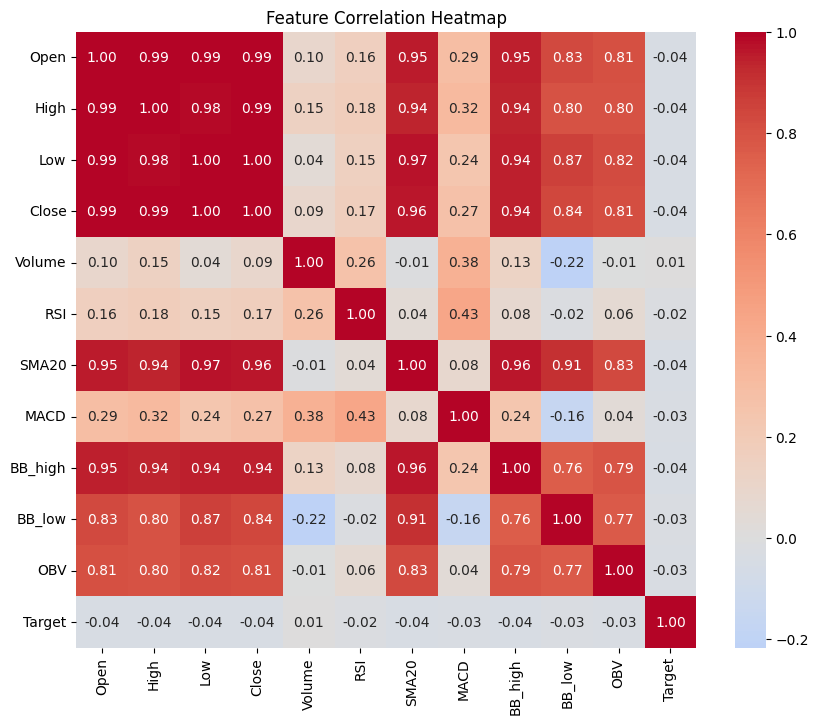

In [55]:
# Data preparation
correlation_matrix = df.corr()
# print(correlation_matrix)

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Included all features
features = ['Open','High','Low','Close','Volume','RSI','SMA20','MACD','BB_high','BB_low','OBV']
target = 'Close'  # Will do regression instead

X = df[features].values
y = df[target].values.reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2489, 11)
y shape: (2489, 1)


In [67]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

print("X_scaled:", X_scaled[:5])
# print("y_scaled:", y_scaled[:5])


X_scaled: [[0.08218639 0.06466519 0.10633943 0.09039556 0.00313812 0.58280745
  0.12033946 0.21821907 0.09690332 0.48213092 0.06000846]
 [0.08255121 0.06538118 0.10744971 0.09097168 0.00244277 0.60054996
  0.12081959 0.2189922  0.09767052 0.48209219 0.06043796]
 [0.08319981 0.06646316 0.10935311 0.09181372 0.0063772  0.62572448
  0.12141975 0.21984198 0.09850576 0.48216998 0.06130429]
 [0.08421323 0.06740192 0.11041054 0.09389665 0.0044557  0.68002779
  0.12221356 0.22119293 0.09966752 0.48221473 0.06195729]
 [0.0860374  0.06908853 0.1116266  0.09597959 0.00652602 0.72388447
  0.12313861 0.22292113 0.1011772  0.48210796 0.06284015]]


In [74]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [68]:
seq_len=20
X_seq, y_seq=[],[]
for i in range(len(X_scaled)-seq_len):
  X_seq.append(X_scaled[i:i+seq_len])
  y_seq.append(y_scaled[i+seq_len])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (2469, 20, 11)
y_seq shape: (2469, 1)


In [69]:
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [78]:
num_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, num_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    shuffle=False
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0069 - val_loss: 3.8544e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0064 - val_loss: 0.0254
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 3.4209e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.9362e-04 - val_loss: 2.0320e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6043e-04 - val_loss: 3.5912e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3753e-04 - val_loss: 1.9624e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6910e-04 - val_loss: 1.8872e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2777e-04 - val_loss: 1.6844e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7592e-04 - val_loss: 2.3942e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2676e-04 - val_loss: 1.7837e-04

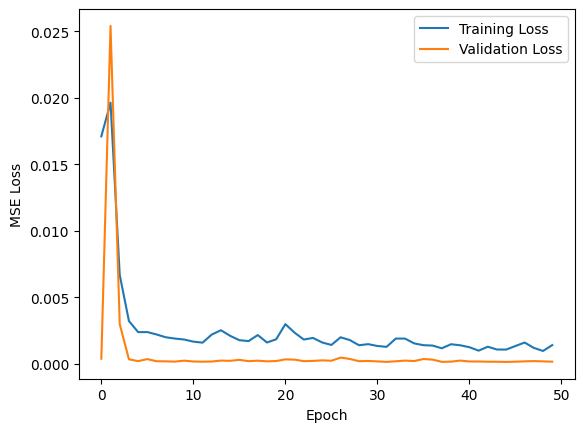

In [80]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [81]:

y_pred_scaled = model.predict(X_test)


y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

MSE : 4.412886366524435
RMSE: 2.100687117712782
MAE : 0.9795125100294106
R²  : 0.8794116219995508


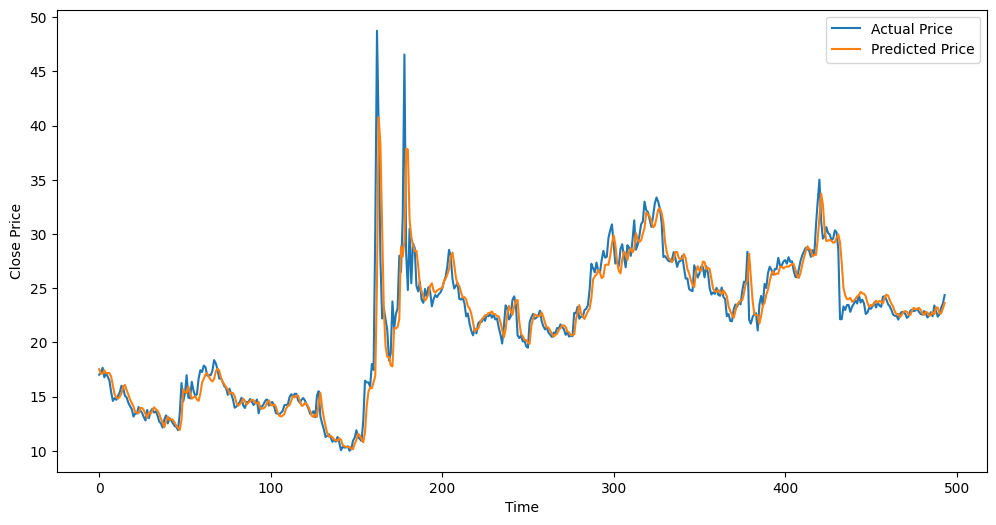

In [85]:
plt.figure(figsize=(12,6))
plt.plot(y_actual, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
